# Model Explanation

# Taining block diagram

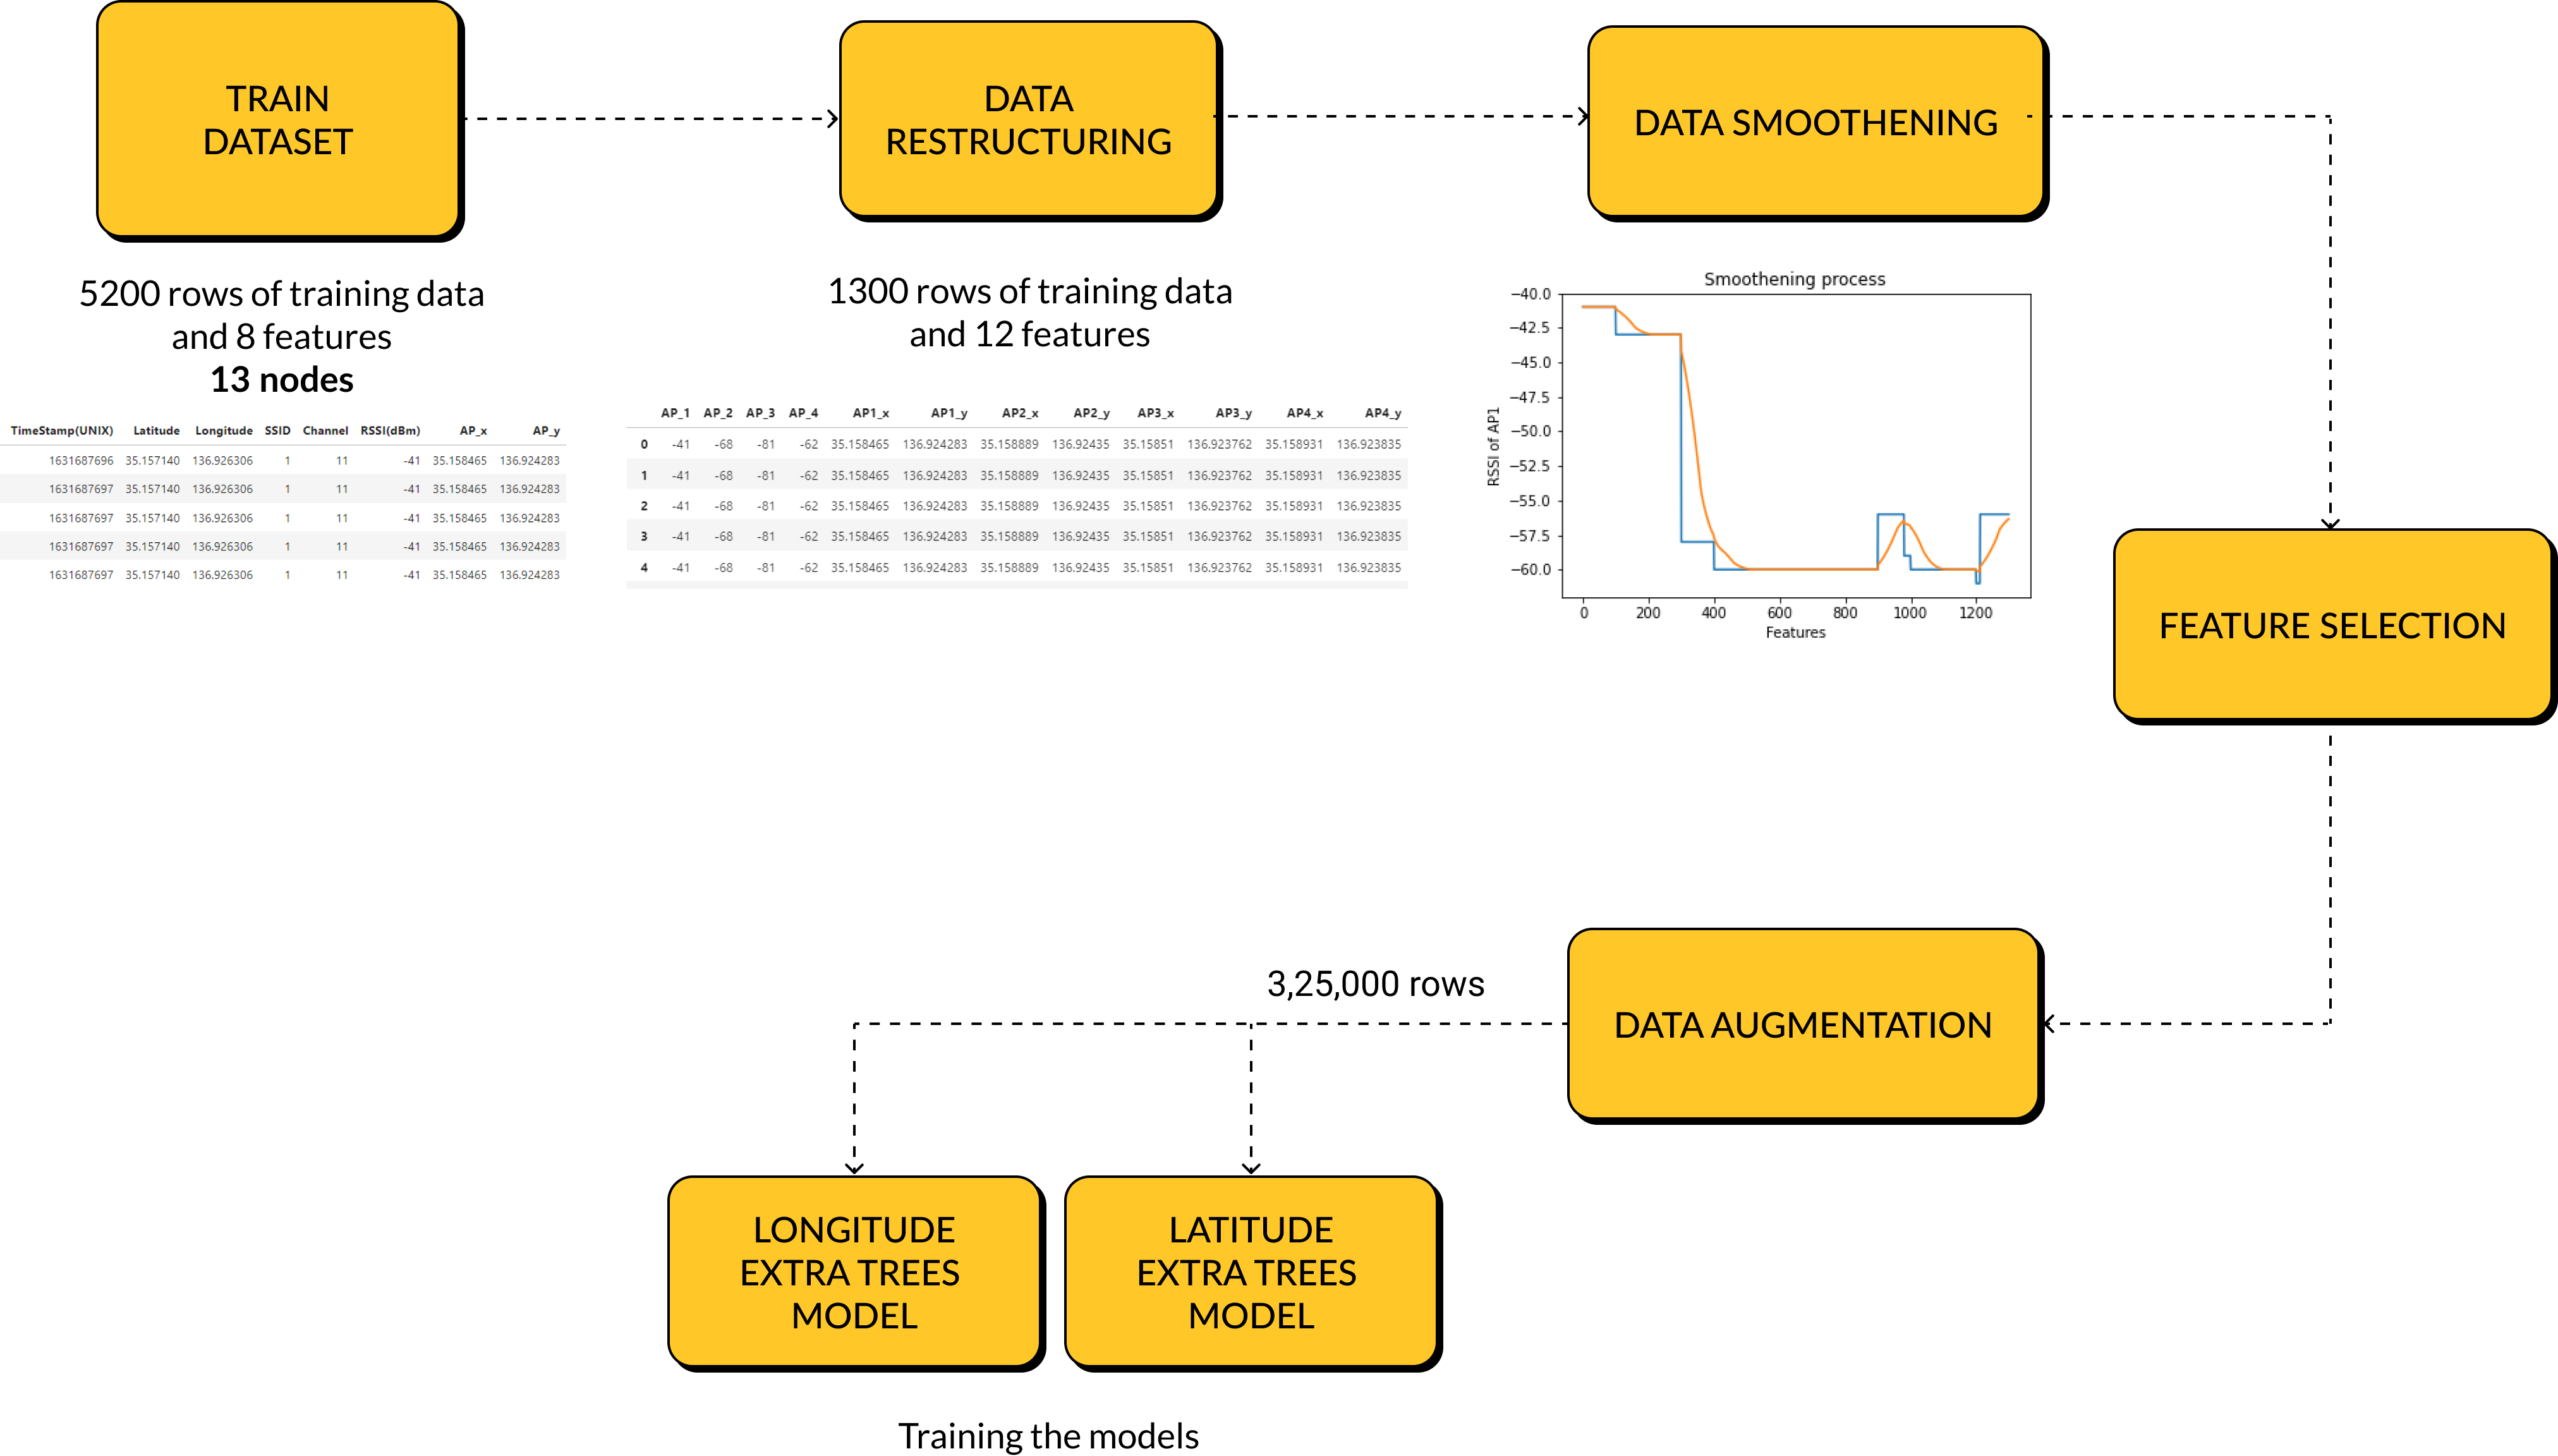

# Testing Block diagram

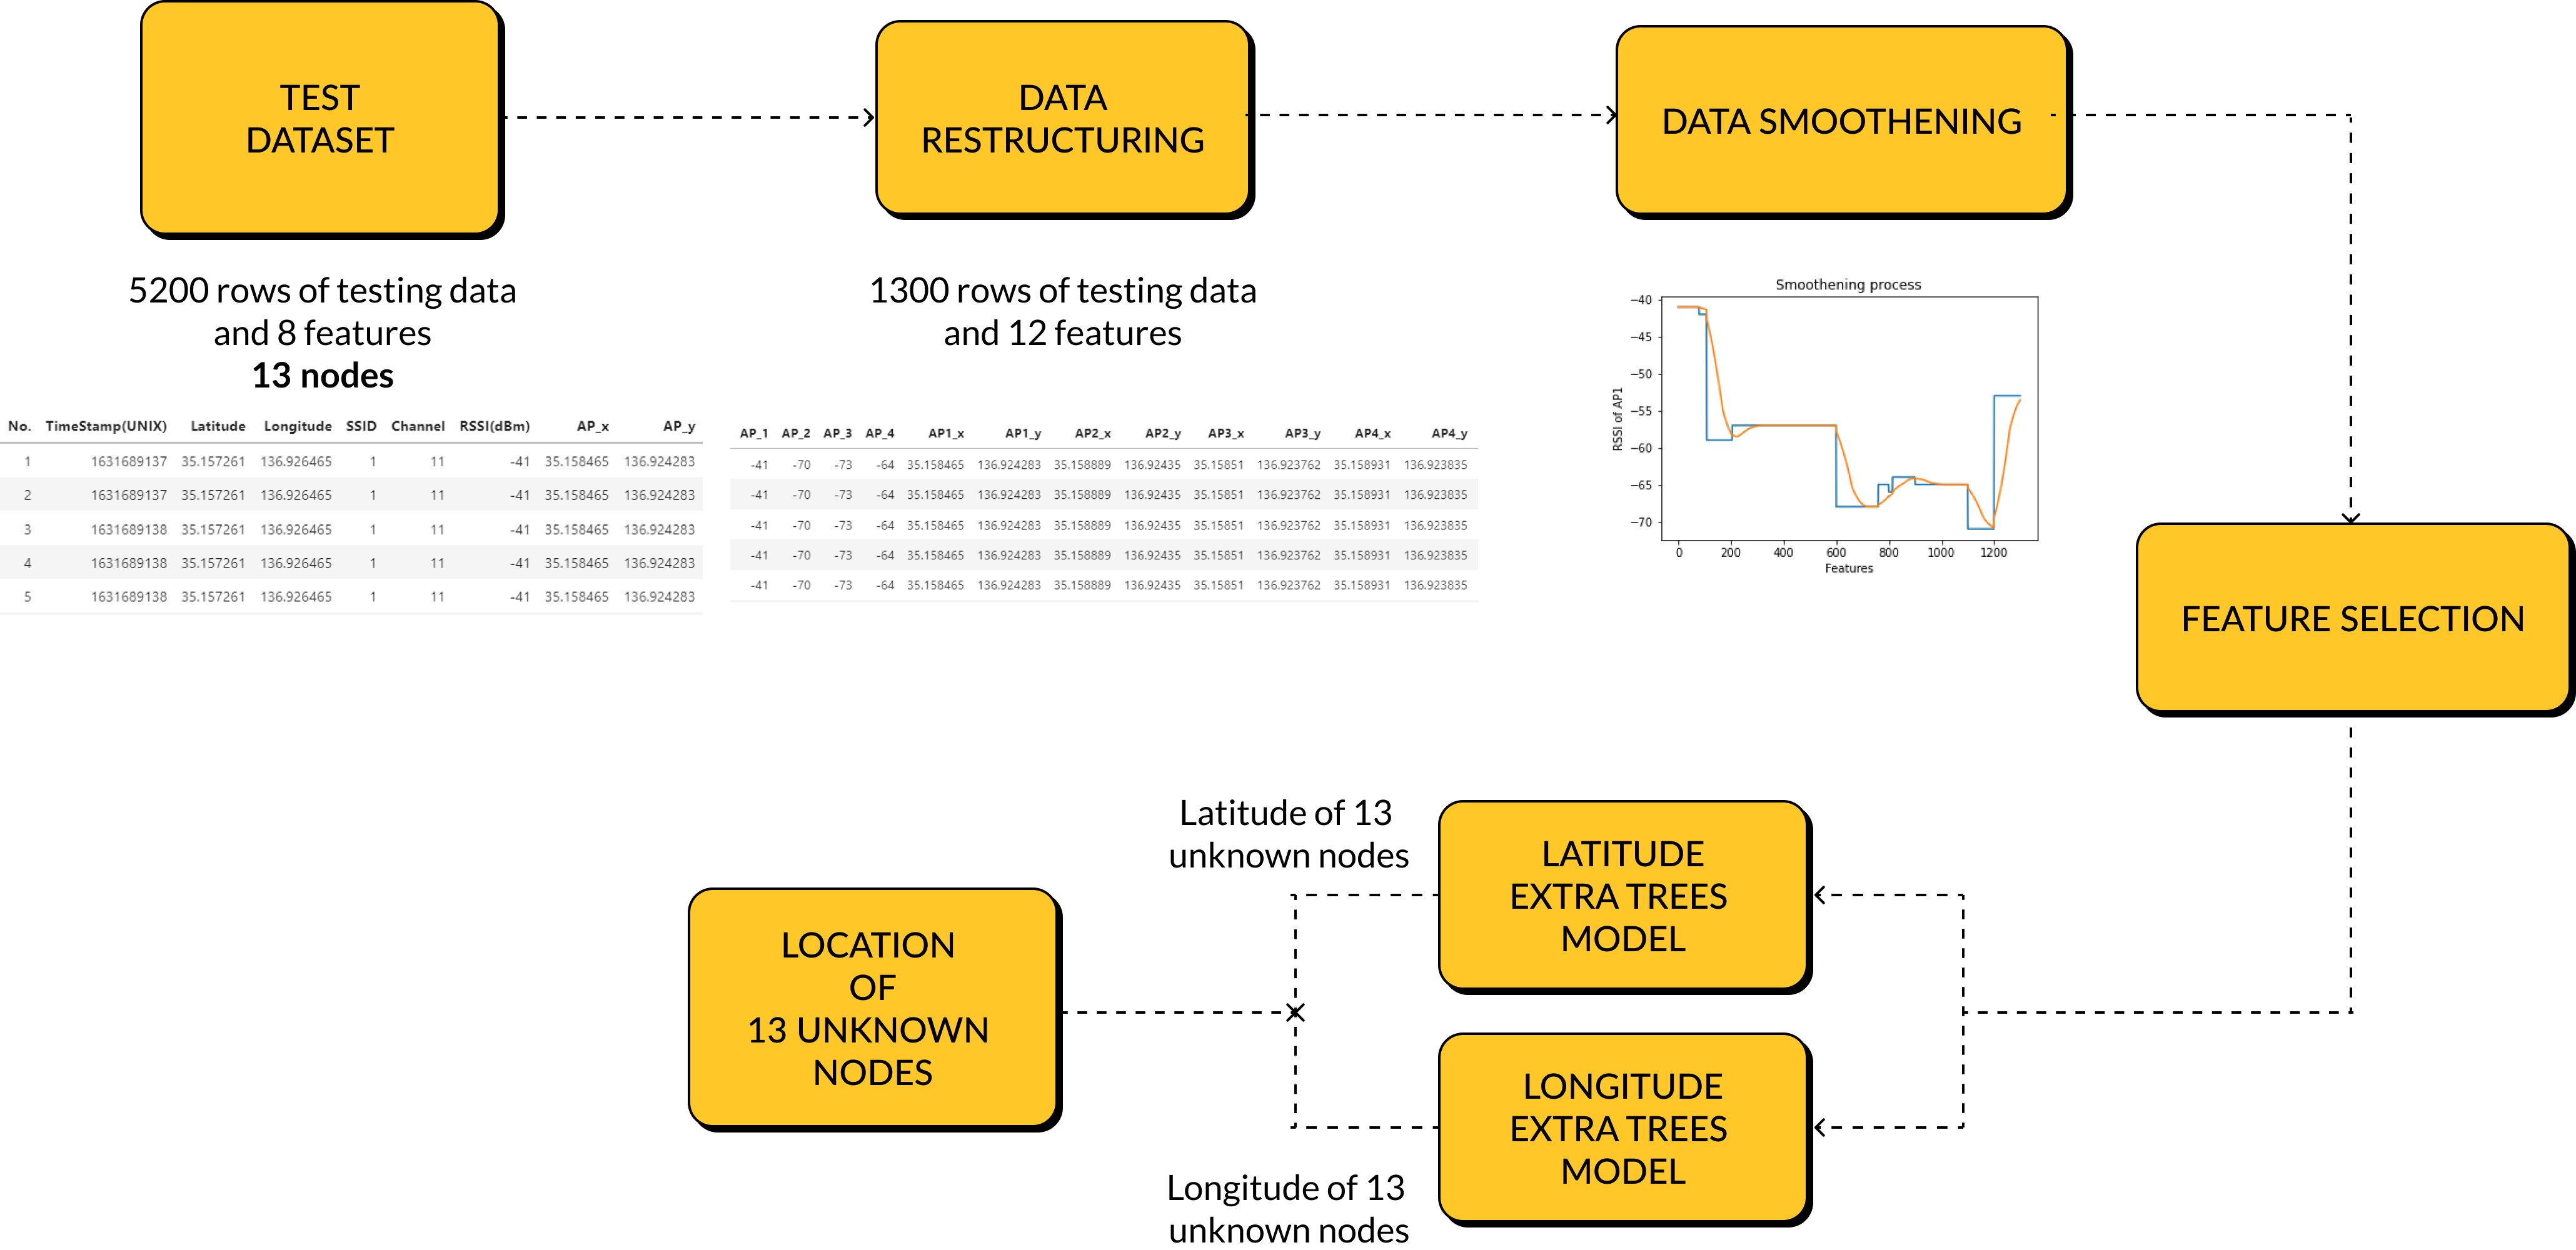

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import time
start_time = time.time()
from matplotlib import pyplot
print("--- %s seconds ---" % (time.time() - start_time))
import matplotlib.pyplot as plt
import statistics

import sklearn.metrics as metrics
from sklearn.ensemble import ExtraTreesRegressor

# Function to calculate distance between a pair of Latitudes and Longitudes

In [2]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 

    c = 2 * asin(sqrt(abs(a)))
    
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371000
      
    # calculate the result
    return(c * r)     

# Restructuring and smoothening the dataset

In [3]:
def cleanDataset_Loc(df, AP_x, AP_y,Access_Points,smoothWindow):
   
    df['AP_x'] = np.select(Access_Points, AP_x)
    df['AP_y'] = np.select(Access_Points, AP_y)
       
        
#     RSSI values from all 4 APs
    AP1 = df["RSSI(dBm)"][:1300]
    AP2 = df["RSSI(dBm)"][1300:2600]
    AP3 = df["RSSI(dBm)"][2600:3900]
    AP4 = df["RSSI(dBm)"][3900:5200]
    
#     Location of all 4 APs
    AP1_x= df["AP_x"][:1300]   
    AP2_x = df["AP_x"][1300:2600]    
    AP3_x = df["AP_x"][2600:3900]   
    AP4_x = df["AP_x"][3900:5200]
    
    AP1_y= df["AP_y"][:1300]  
    AP2_y = df["AP_y"][1300:2600] 
    AP3_y = df["AP_y"][2600:3900]   
    AP4_y = df["AP_y"][3900:5200]
    AP4_y.head()
    AP1_list = AP1.tolist()
    AP2_list = AP2.tolist()
    AP3_list = AP3.tolist()
    AP4_list = AP4.tolist()
    
            
    
    AP1_x_list = AP1_x.tolist()
    AP2_x_list = AP2_x.tolist()
    AP3_x_list = AP3_x.tolist()
    AP4_x_list = AP4_x.tolist()
    AP1_y_list = AP1_y.tolist()
    AP2_y_list = AP2_y.tolist()
    AP3_y_list = AP3_y.tolist()
    AP4_y_list = AP4_y.tolist()

    print("Shape of AP1_list: ", len(AP1_list))
#     Saving df
    train_1 = df.copy(deep=True)
    
#     Keeping only 
    train_1.drop(train_1[-3900:].index, inplace = True)
    train_1.head()
    
#     Insert all columns
    train_1.insert(9, "AP_1", AP1_list)
    train_1.insert(10, "AP_2", AP2_list)
    train_1.insert(11, "AP_3", AP3_list)
    train_1.insert(12, "AP_4", AP4_list)
    train_1.insert(13,"AP1_x", AP1_x_list)
    train_1.insert(14, "AP1_y", AP1_y_list)
    train_1.insert(15, "AP2_x", AP2_x_list)
    train_1.insert(16, "AP2_y", AP2_y_list)
    train_1.insert(17, "AP3_x", AP3_x_list)
    train_1.insert(18, "AP3_y", AP3_y_list)
    train_1.insert(19, "AP4_x", AP4_x_list)
    train_1.insert(20, "AP4_y", AP4_y_list)
    AP_1_smooth = ([]);
    AP_2_smooth = ([]);
    AP_3_smooth = ([]);
    AP_4_smooth = ([]);
    
    alpha = 0.4;
    window_size = smoothWindow;
    
    for j in range(0, 1300):
            if (j<window_size):
                AP_1_smooth = np.append(AP_1_smooth, train_1['AP_1'][j])
                AP_2_smooth = np.append(AP_2_smooth, train_1["AP_2"][j])
                AP_3_smooth = np.append(AP_3_smooth, train_1["AP_3"][j])
                AP_4_smooth = np.append(AP_4_smooth, train_1["AP_4"][j])

            else:
                s = sum(train_1['AP_1'][j-window_size:j].to_list())/window_size;
                AP_1_smooth = np.append(AP_1_smooth, train_1['AP_1'][j]*alpha + (1-alpha)*s);
                s = sum(train_1['AP_2'][j-window_size:j].to_list())/window_size;
                AP_2_smooth = np.append(AP_2_smooth, train_1['AP_2'][j]*alpha + (1-alpha)*s);
                s = sum(train_1['AP_3'][j-window_size:j].to_list())/window_size;
                AP_3_smooth = np.append(AP_3_smooth, train_1['AP_3'][j]*alpha + (1-alpha)*s);
                s = sum(train_1['AP_4'][j-window_size:j].to_list())/window_size;
                AP_4_smooth = np.append(AP_4_smooth, train_1['AP_4'][j]*alpha + (1-alpha)*s);
                
    AP_1_smooth2 = ([]);
    AP_2_smooth2 = ([]);
    AP_3_smooth2 = ([]);
    AP_4_smooth2 = ([]);
                
    alpha = 0.2;
    for j in range(0, 1300):
            if (j<window_size):
                AP_1_smooth2 = np.append(AP_1_smooth2, AP_1_smooth[j])
                AP_2_smooth2 = np.append(AP_2_smooth2, AP_2_smooth[j])
                AP_3_smooth2 = np.append(AP_3_smooth2, AP_3_smooth[j])
                AP_4_smooth2 = np.append(AP_4_smooth2, AP_4_smooth[j])

            else:
                s = sum(AP_1_smooth[j-window_size:j])/window_size;
                AP_1_smooth2 = np.append(AP_1_smooth2, AP_1_smooth[j]*alpha + (1-alpha)*s);
                s = sum(AP_2_smooth[j-window_size:j])/window_size;
                AP_2_smooth2 = np.append(AP_2_smooth2, AP_2_smooth[j]*alpha + (1-alpha)*s);
                s = sum(AP_3_smooth[j-window_size:j])/window_size;
                AP_3_smooth2 = np.append(AP_3_smooth2, AP_3_smooth[j]*alpha + (1-alpha)*s);
                s = sum(AP_4_smooth[j-window_size:j])/window_size;
                AP_4_smooth2 = np.append(AP_4_smooth2, AP_4_smooth[j]*alpha + (1-alpha)*s);
                
    plt.title("Smoothening process")
    plt.xlabel("Features")
    plt.ylabel("RSSI of AP1")
    plt.plot(train_1['AP_1']);
    plt.plot(AP_1_smooth2)
    plt.show()

    train_1.insert(21, "AP_1_smooth", AP_1_smooth2)
    train_1.insert(22, "AP_2_smooth", AP_2_smooth2)
    train_1.insert(23, "AP_3_smooth", AP_3_smooth2)
    train_1.insert(24, "AP_4_smooth", AP_4_smooth2)

    Y = train_1[['Latitude', 'Longitude']]

    X = train_1.drop(columns = ['Latitude', 'Longitude', 'SSID','No.','TimeStamp(UNIX)', 'RSSI(dBm)','Channel','AP_x','AP_y'])
    X = pd.concat([X,Y], axis = 1)
    
        
    return X

# Data Augmentation

In [4]:
# r is the dataset
# num is the number of times you want to repeat 

def dataAugmentation(r, num):
    final_df = pd.DataFrame(data = {'AP_1': [], 'AP_2':[], 'AP_3':[], 'AP_4':[], 'AP1_x':[], 
                                'AP1_y':[], 'AP2_x':[], 'AP2_y':[], 'AP3_x':[], 'AP3_y':[], 'AP4_x':[], 
                                'AP4_y':[],'AP_1_smooth' : [], 'AP_2_smooth' : [], 'AP_3_smooth' : [], 
                                'AP_4_smooth' : [], 'Latitude' : [], 'Longitude' : [] }) 
    
    y = r['Latitude'].copy().to_list()
    new_list = pd.unique(r['Latitude']).tolist()
    
    for y1 in new_list:
        Grid_1 = pd.DataFrame(data = {'AP_1': [], 'AP_2':[], 'AP_3':[], 'AP_4':[], 'AP1_x':[], 
                                      'AP1_y':[], 'AP2_x':[], 'AP2_y':[], 'AP3_x':[], 'AP3_y':[], 
                                      'AP4_x':[], 'AP4_y':[],'AP_1_smooth' : [], 'AP_2_smooth' : [], 
                                      'AP_3_smooth' : [], 'AP_4_smooth' : [], 'Latitude' : [], 'Longitude' : [] })
        for i in range(1300):
            if r.iloc[i]['Latitude'] == y1:
                Grid_1 = Grid_1.append(r.iloc[i])
        sampled_df = pd.DataFrame(data = {'AP_1': [], 'AP_2':[], 'AP_3':[], 'AP_4':[], 
                                          'AP1_x':[], 'AP1_y':[], 'AP2_x':[], 'AP2_y':[], 
                                          'AP3_x':[], 'AP3_y':[], 'AP4_x':[], 'AP4_y':[],
                                          'AP_1_smooth' : [], 'AP_2_smooth' : [], 'AP_3_smooth' : [], 
                                          'AP_4_smooth' : [], 'Latitude' : [], 'Longitude' : [] })
        sampled_df['AP_1'] = Grid_1['AP_1'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP_2'] = Grid_1['AP_2'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP_3'] = Grid_1['AP_3'].sample(n = num, random_state= 123, replace = True).to_list()
        #sampled_df['AP_4'] = Grid_1['AP_4'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP_4'] = Grid_1['AP_4'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP1_x'] = Grid_1['AP1_x'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP1_y'] = Grid_1['AP1_y'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP2_x'] = Grid_1['AP2_x'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP2_y'] = Grid_1['AP2_y'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP3_x'] = Grid_1['AP3_x'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP3_y'] = Grid_1['AP3_y'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP4_x'] = Grid_1['AP4_x'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP4_y'] = Grid_1['AP4_y'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP_1_smooth'] = Grid_1['AP_1_smooth'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP_2_smooth'] = Grid_1['AP_2_smooth'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP_3_smooth'] = Grid_1['AP_3_smooth'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['AP_4_smooth'] = Grid_1['AP_4_smooth'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['Latitude'] = Grid_1['Latitude'].sample(n = num, random_state= 123, replace = True).to_list()
        sampled_df['Longitude'] = Grid_1['Longitude'].sample(n = num, random_state= 123, replace = True).to_list()
        if y1 == 1:
            temp_df = pd.DataFrame()
            final_df = temp_df.append(sampled_df,ignore_index = True)
        else:
            final_df = final_df.append(sampled_df,ignore_index = True)
            
    return final_df

# Feature selection

In [5]:
def select_features(X_train, y_train):
    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    return fs

In [6]:
def featureSelection(xtrain_loc, ytrain_lon):
    remove_cols = []
    fs = select_features(xtrain_loc, ytrain_lon)

    # what are scores for the features-gives amount of impact of target variables
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i, fs.scores_[i]))

        if fs.scores_[i] < 0:
            remove_cols.append(i)

    # plot the scores
    pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
    #pyplot.show()
    pyplot.title("Feature Selection")
    pyplot.xlabel("Features")
    pyplot.ylabel("Feature Score")
    pyplot.savefig("featureSelection")
    xtrain_loc.columns
    return remove_cols

# Extra Trees Regression Model

## For Latitude

In [7]:
def extraTrees_LatModel(X_train, ytrain_lat):
    
    extra_trees_regressor_lat = ExtraTreesRegressor()
    extra_trees_regressor_lat.fit(X_train,ytrain_lat)

    return extra_trees_regressor_lat

## For Longitude

In [8]:
def extraTrees_LonModel(X_train, ytrain_lon):
    
    extra_trees_regressor_lon = ExtraTreesRegressor()
    extra_trees_regressor_lon.fit(X_train,ytrain_lon)

    return extra_trees_regressor_lon

# Training 

In [9]:
def training(df_link, AP_loc_x, AP_loc_y, smoothWindow, numAugmentation):
    df_1 = pd.read_csv(df_link)
    AP_x_1= AP_loc_x
    AP_y_1 = AP_loc_y
    Access_Points_train_1 = [(df_1['SSID'] == 1),(df_1['SSID'] == 2),(df_1['SSID'] == 3),(df_1['SSID'] == 4)]
       
        
#     Original dataset
    print("Original dataset: ")
    print(df_1);
    
#     After smoothening and rearranging the dataset
    r = cleanDataset_Loc(df_1, AP_x_1, AP_y_1,Access_Points_train_1, smoothWindow)
    
   
    
#     DATA AUGMENTATION   
    
    num = numAugmentation
    final_df = dataAugmentation(r, num);    
    
    print("Shape of training dataset after augmenting: ", final_df.shape)
    
    ytrain_wifi1_loc = final_df[["Latitude", "Longitude"]]
    xtrain_wifi1_loc = final_df.drop(columns=["Latitude", "Longitude"])
    
    

#     Splitting the dataste into features and lat and long
    
    xtrain_loc = xtrain_wifi1_loc.copy(deep="True")
    ytrain_loc = ytrain_wifi1_loc.copy(deep="True")
    
    ytrain_lat = ytrain_loc.drop(columns = 'Longitude')
    ytrain_lon = ytrain_loc.drop(columns = 'Latitude')
    
    
#     Feature Selection     
    remove_cols = featureSelection(xtrain_loc, ytrain_lon)
    print("Columns to be removed: ", remove_cols)
    X_train = xtrain_loc.drop(xtrain_loc.columns[remove_cols], axis=1)
    
#     Latitude model
    extra_trees_regressor_lat = extraTrees_LatModel(X_train, ytrain_lat)
    
#     Longitude model
    extra_trees_regressor_lon = extraTrees_LonModel(X_train, ytrain_lon)
    
    
    return remove_cols, extra_trees_regressor_lat, extra_trees_regressor_lon

# Testing

In [16]:
def testing(df_link, AP_loc_x, AP_loc_y, smoothWindow, remove_cols, extra_trees_regressor_lat, extra_trees_regressor_lon):
    df_2 = pd.read_csv(df_link)
    AP_x_1= AP_loc_x
    AP_y_1 = AP_loc_y
   
    Access_Points_test_1= [(df_2['SSID'] == 1),(df_2['SSID'] == 2),(df_2['SSID'] == 3),(df_2['SSID'] == 4)]
    
      
    
#     Original testing dataset
    print("Original Dataset: ")
    print(df_2);
    
#     After smoothening and rearranging the testing dataset
    r_2 = cleanDataset_Loc(df_2, AP_x_1, AP_y_1,Access_Points_test_1, smoothWindow)
    print("\nDataset after restructuring and smoothening")
    print(r_2.head())
          
        
    num = 1000
    final_df = dataAugmentation(r, num);    
    
    print("Shape of training dataset after augmenting: ", final_df.shape)
    
    ytest_wifi1_loc = final_df[["Latitude", "Longitude"]]
    xtest_wifi1_loc = final_df.drop(columns=["Latitude", "Longitude"])
    
     
#     ytest_wifi1_loc = r_2[["Latitude", "Longitude"]]
#     xtest_wifi1_loc = r_2.drop(columns=["Latitude", "Longitude"])


#     Splitting the dataste into features and lat and long    
    xtest_loc = xtest_wifi1_loc.copy(deep="True")
    ytest_loc = ytest_wifi1_loc.copy(deep="True")
    
    ytest_lat = ytest_loc.drop(columns = 'Longitude')
    ytest_lon = ytest_loc.drop(columns = 'Latitude')
    
       
        
#     Feature Selection   
    X_test = xtest_loc.drop(xtest_loc.columns[remove_cols], axis=1)
    
    print("\nTesting features after feature selection:");
    print( X_test)
    
    
    print("Error in Predicting Latitude:")
    y_pred_extra_trees_lat = extra_trees_regressor_lat.predict(X_test)    
    mean_absolute_error=metrics.mean_absolute_error(ytest_lat, y_pred_extra_trees_lat) 
    MSE=metrics.mean_squared_error(ytest_lat, y_pred_extra_trees_lat) 
    RMSE= np.sqrt(MSE)
    R2=metrics.r2_score(ytest_lat, y_pred_extra_trees_lat)
    max_error= metrics.max_error(ytest_lat, y_pred_extra_trees_lat)
    print('Mean Absolute Error:', mean_absolute_error)
    print('Mean Squared Error:',MSE)
    print('Root Mean Squared Error:',RMSE)
    print('Maximum error:',max_error)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    
    print("\n\nError in Predicting Longitude:")
    y_pred_extra_trees_lon = extra_trees_regressor_lon.predict(X_test)
    mean_absolute_error=metrics.mean_absolute_error(ytest_lon, y_pred_extra_trees_lon) 
    MSE=metrics.mean_squared_error(ytest_lon, y_pred_extra_trees_lon) 
    RMSE= np.sqrt(MSE)
    R2=metrics.r2_score(ytest_lon, y_pred_extra_trees_lon)
    max_error= metrics.max_error(ytest_lon, y_pred_extra_trees_lon)
    print('Mean Absolute Error:', mean_absolute_error)
    print('Mean Squared Error:', MSE)
    print('Root Mean Squared Error:', RMSE)
    print('Maximum error:', max_error)
    print("--- %s seconds ---" % (time.time() - start_time))

    
    print("\n\nPredicting Location:")
    lat = ([]);
    lon = ([]);
    x=([])
    sum=0;
    for i in range(0,13000):
        xtest = X_test.iloc[i].to_numpy().reshape(1,-1)    
        lat_2 = extra_trees_regressor_lat.predict(xtest)
        lon_2 = extra_trees_regressor_lon.predict(xtest)
        lat = np.append(lat, lat_2);
        lon = np.append(lon, lon_2);
        sum = sum + distance(lat_2, ytest_lat.values[i], lon_2, ytest_lon.values[i])
        if (i+1)%1000==0:
            print("Error of unknown loc ",(i+1)//1000,": ", sum/1000)
            x.append(sum/1000)
            sum=0;               
    print("Maximum error in metres",": ", max(x)) 
    s = 0;
    for i in range(13):
        s = s+x[i]
    print("Average error in metres",": ", s/13)       
        

# RUNNING THE MODEL

In [11]:
trainDataset_link = '../input/full-dataset/Dataset_2/Dataset_for_grand_finale.zip (Unzipped Files)/training_dataset.csv';
df_1 = pd.read_csv(trainDataset_link)
AP_x_1= [35.1573202, 35.157347, 35.1572018, 35.157165]
AP_y_1 = [136.926447,136.9268074,136.9268269,136.9264698]
Access_Points_train_1 = [(df_1['SSID'] == 1),(df_1['SSID'] == 2),(df_1['SSID'] == 3),(df_1['SSID'] == 4)]
       
        
#     Original dataset
print("Original dataset: ")
print(df_1);
    
#     After smoothening and rearranging the dataset
r = cleanDataset_Loc(df_1, AP_x_1, AP_y_1,Access_Points_train_1, 60)

for i in range(0,1300,100):
    print(r['Latitude'][i], r['Longitude'][i])

plt.scatter(r['Latitude'], r['Longitude'])
   

In [17]:
trainDataset_link = '../input/full-dataset/Dataset_2/Dataset_for_grand_finale.zip (Unzipped Files)/training_dataset.csv';

AP_x_1= [35.1573202, 35.157347, 35.1572018, 35.157165]
AP_y_1 = [136.926447,136.9268074,136.9268269,136.9264698]
    
remove_cols, extra_trees_regressor_lat, extra_trees_regressor_lon = training(trainDataset_link,AP_x_1, AP_y_1, 60, numAugmentation = 10000 )


In [18]:
testDataset_link = '../input/full-dataset/Dataset_2/Dataset_for_grand_finale.zip (Unzipped Files)/verification_dataset.csv';
AP_x_1= [35.1573202, 35.157347, 35.1572018, 35.157165]
AP_y_1 = [136.926447,136.9268074,136.9268269,136.9264698]

testing(testDataset_link, AP_x_1, AP_y_1, 60, remove_cols, extra_trees_regressor_lat, extra_trees_regressor_lon)

import time
start_time = time.time()
from matplotlib import pyplot
print("\nLatency")
print("--- %s seconds ---" % (time.time() - start_time))

# Pickling the model

In [ ]:
# import pickle
# with open('Lat_Model.pkl', 'wb') as file:  
#     pickle.dump(extra_trees_regressor_lat, file)

# with open('Lon_Model.pkl', 'wb') as file:  
#     pickle.dump(extra_trees_regressor_lon, file)   


# Loading model

In [ ]:
# import pickle
# with open('../input/full-dataset/Lat_Model.pkl', 'rb') as file:  
#     extra_trees_regressor_lat = pickle.load(file)
    
# with open('../input/full-dataset/Lat_Model.pkl', 'rb') as file:  
#     extra_trees_regressor_lon = pickle.load(file)